### Import statements

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### DataMerging

In [3]:
# Load the CSV files
data = pd.read_csv("/content/drive/MyDrive/MSc Dessertation/DATASETS/TCGA-PANCAN-HiSeq-801x20531/TCGA-PANCAN-HiSeq-801x20531/data.csv")
labels = pd.read_csv("/content/drive/MyDrive/MSc Dessertation/DATASETS/TCGA-PANCAN-HiSeq-801x20531/TCGA-PANCAN-HiSeq-801x20531/labels.csv")

# Merge the datasets using 'Unnamed: 0' as the key
merged_data = pd.merge(data, labels, on="Unnamed: 0")

# Reorder columns: 'Unnamed: 0', all features, 'Class'
columns_order = ["Unnamed: 0"] + [col for col in merged_data.columns if col not in ["Unnamed: 0", "Class"]] + ["Class"]
merged_data = merged_data[columns_order]

# Save the merged dataset to a new CSV file
merged_data.to_csv("combined_data1.csv", index=False)

# Load the cancer dataset
data = pd.read_csv('combined_data1.csv')

### Label Encoding

In [4]:
# Label encode any non-numeric columns
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Adjust selection based on the actual number of columns
n_columns = min(5000, data.shape[1] - 1)  # Keep space for 'Class' column
data = data.iloc[:600, :n_columns].copy()

In [5]:
# Add the 'Class' column if not included in selection
if 'Class' not in data.columns:
    data['Class'] = pd.read_csv('combined_data1.csv')['Class'][:500]

## insights of data

In [6]:
# Separate features and target
X = data.iloc[:, :-1]  # All columns except last for features
y = data.iloc[:, -1]   # Last column for target
y = LabelEncoder().fit_transform(y)

In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
import warnings
warnings.filterwarnings('ignore')

## Optimization and Baseline Model Creation

Baseline Random Forest Accuracy: 75.8333%
Number of Features Used: 5000


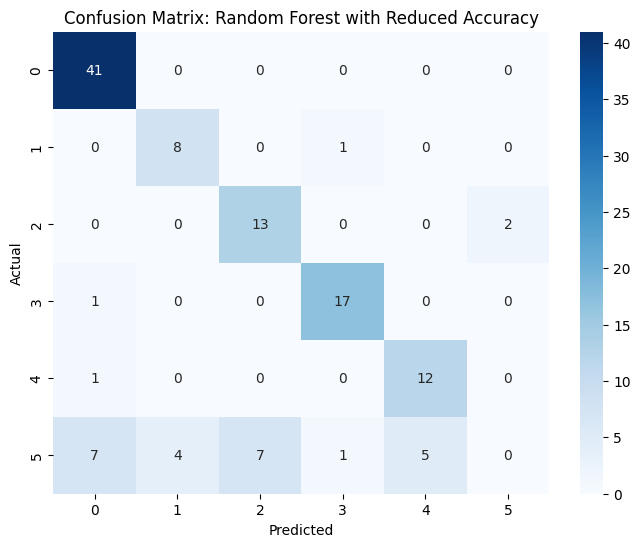

Classification Report for Random Forest with Reduced Accuracy:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        41
           1       0.67      0.89      0.76         9
           2       0.65      0.87      0.74        15
           3       0.89      0.94      0.92        18
           4       0.71      0.92      0.80        13
           5       0.00      0.00      0.00        24

    accuracy                           0.76       120
   macro avg       0.62      0.77      0.69       120
weighted avg       0.62      0.76      0.68       120



In [9]:
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest Classifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Train Random Forest Baseline Model with Reduced Performance
baseline_model = RandomForestClassifier(
    n_estimators=10,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='log2',
    random_state=42
)

baseline_model.fit(X_train, y_train)

# Predict on the test set
baseline_predictions = baseline_model.predict(X_test)

# Evaluate accuracy
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
print(f"Baseline Random Forest Accuracy: {baseline_accuracy:.4%}")

# Print the number of features used
num_features = X_train.shape[1]
print(f"Number of Features Used: {num_features}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, baseline_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Random Forest with Reduced Accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report for Random Forest with Reduced Accuracy:")
print(classification_report(y_test, baseline_predictions))

# AUC-ROC Score (if binary classification)
if len(np.unique(y_test)) == 2:  # Only for binary classification
    baseline_auc = roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:, 1])
    print(f"Baseline Random Forest AUC-ROC: {baseline_auc:.4f}")


## Applying Stochastic Diffusion Search (SDS)

In [10]:
# 2. Custom SDS (Stochastic Diffusion Search) Implementation
class SDS:
    def __init__(self, n_agents, n_iterations, model):
        self.n_agents = n_agents
        self.n_iterations = n_iterations
        self.model = model
        self.best_feature_subset = None
        self.best_accuracy = 0.0

    def initialize_agents(self, n_features):
        agents = []
        for _ in range(self.n_agents):
            agent_features = np.random.choice([0, 1], size=n_features)
            agents.append(agent_features)
        return np.array(agents)

    def evaluate(self, agent_features, X, y):
        selected_features = agent_features  # Indices of selected features

        # Ensure the selected features are valid for indexing
        if len(selected_features) == 0:
            return 0.0

        # Use .iloc to select rows and columns based on integer indexing
        X_selected = X.iloc[:, selected_features]

        # Fit the model and evaluate the performance
        self.model.fit(X_selected, y)
        predictions = self.model.predict(X_selected)
        accuracy = accuracy_score(y, predictions)

        return accuracy

    def search(self, X_train, y_train):
        n_features = X_train.shape[1]
        agents = self.initialize_agents(n_features)

        for iteration in range(self.n_iterations):
            print(f"Iteration {iteration + 1}/{self.n_iterations}")

            for i, agent in enumerate(agents):
                agent_accuracy = self.evaluate(agent, X_train, y_train)

                if agent_accuracy != self.best_accuracy:
                    self.best_accuracy = agent_accuracy
                    self.best_feature_subset = agent.copy()
                    print(f"New best accuracy: {self.best_accuracy:.4f} with features {np.where(agent == 1)[0]}")

            # Diffuse the best feature subset among agents
            for i in range(len(agents)):
                agents[i] = self.best_feature_subset if np.random.rand() > 0.5 else agents[i]

        print(f"Best Feature Subset: {np.where(self.best_feature_subset == 1)[0]}")
        return self.best_feature_subset

Iteration 1/15
New best accuracy: 1.0000 with features [   1    4    5 ... 4992 4993 4994]
Iteration 2/15
Iteration 3/15
Iteration 4/15
Iteration 5/15
Iteration 6/15
Iteration 7/15
Iteration 8/15
Iteration 9/15
Iteration 10/15
Iteration 11/15
Iteration 12/15
Iteration 13/15
Iteration 14/15
Iteration 15/15
Best Feature Subset: [   1    4    5 ... 4992 4993 4994]
SDS-selected Features Accuracy: 78.3333%
Classification Report for SDS-selected Features:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        41
           1       0.69      1.00      0.82         9
           2       0.67      0.93      0.78        15
           3       0.95      1.00      0.97        18
           4       0.71      0.92      0.80        13
           5       0.00      0.00      0.00        24

    accuracy                           0.78       120
   macro avg       0.64      0.81      0.72       120
weighted avg       0.65      0.78      0.71       120



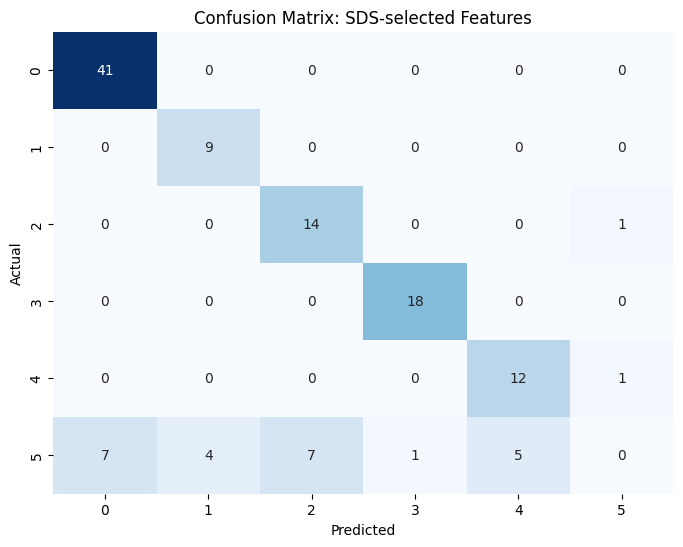

In [11]:
# Initialize the SDS with a RandomForest model for feature selection
rf_model = RandomForestClassifier(random_state=42)
sds = SDS(n_agents=10, n_iterations=15, model=rf_model)

# Run SDS to find the best feature subset
best_features = sds.search(X_train, y_train)

# Evaluate the RandomForest model on the test set using the SDS-selected features
selected_features_indices = np.where(best_features == 1)[0]
X_train_sds = X_train.iloc[:, selected_features_indices]
X_test_sds = X_test.iloc[:, selected_features_indices]
rf_model.fit(X_train_sds, y_train)
sds_predictions = rf_model.predict(X_test_sds)
sds_accuracy = accuracy_score(y_test, sds_predictions)
print(f"SDS-selected Features Accuracy: {sds_accuracy:.4%}")

# Classification Report
print("Classification Report for SDS-selected Features:")
print(classification_report(y_test, sds_predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, sds_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: SDS-selected Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# AUC-ROC Score (if binary classification)
if len(np.unique(y_test)) == 2:  # Only calculate AUC-ROC for binary classification
    sds_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_sds)[:, 1])
    print(f"SDS-selected Features AUC-ROC Score: {sds_auc:.4f}")



## Applying Principal Component Analysis (PCA)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, r2_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Apply PCA and retain components that explain 95% of the variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Use Logistic Regression for classification
pca_model = LogisticRegression()  # Replace LinearRegression with LogisticRegression
pca_model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = pca_model.predict(X_test_pca)
if len(set(y_train)) > 2:
    # Multi-class classification
    y_pred_proba = pca_model.predict_proba(X_test_pca)
    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
else:
    # Binary classification
    y_pred_proba = pca_model.predict_proba(X_test_pca)[:, 1]
    auc_roc = roc_auc_score(y_test, y_pred_proba)

# Evaluate the model
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
pca_accuracy = pca_model.score(X_test_pca, y_test) * 100

# Print results
print(f"PCA-transformed Features Accuracy: {pca_accuracy:.2f}%")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Plot the ROC curve if binary classification
if len(set(y_train)) == 2:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.show()


PCA-transformed Features Accuracy: 75.83%
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        41
           1       0.64      0.78      0.70         9
           2       0.85      0.73      0.79        15
           3       0.89      0.89      0.89        18
           4       0.72      1.00      0.84        13
           5       0.42      0.33      0.37        24

    accuracy                           0.76       120
   macro avg       0.73      0.77      0.74       120
weighted avg       0.75      0.76      0.75       120

Confusion Matrix:
 [[36  0  0  0  0  5]
 [ 0  7  0  0  0  2]
 [ 0  0 11  2  0  2]
 [ 0  0  0 16  0  2]
 [ 0  0  0  0 13  0]
 [ 5  4  2  0  5  8]]
AUC-ROC Score: 0.9503


## Applying Recursive Feature Elimination (RFE)

In [13]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Initialize RFE with Logistic Regression as the model
rfe_model = LogisticRegression()  # Using Logistic Regression for classification
rfe = RFE(estimator=rfe_model, step=50)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)
rfe_model.fit(X_train_rfe, y_train)

# Predict on the test set
y_pred = rfe_model.predict(X_test_rfe)
if len(set(y_train)) > 2:
    # Multi-class classification
    y_pred_proba = rfe_model.predict_proba(X_test_rfe)
    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
else:
    # Binary classification
    y_pred_proba = rfe_model.predict_proba(X_test_rfe)[:, 1]
    auc_roc = roc_auc_score(y_test, y_pred_proba)

# Evaluate the model
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
rfe_accuracy = rfe_model.score(X_test_rfe, y_test) * 100

# Print results
print(f"RFE-selected Features Accuracy: {rfe_accuracy:.2f}%")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Plot the ROC curve if binary classification
if len(set(y_train)) == 2:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.show()


RFE-selected Features Accuracy: 76.67%
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89        41
           1       0.73      0.89      0.80         9
           2       0.92      0.73      0.81        15
           3       1.00      0.78      0.88        18
           4       0.73      0.85      0.79        13
           5       0.42      0.46      0.44        24

    accuracy                           0.77       120
   macro avg       0.78      0.77      0.77       120
weighted avg       0.78      0.77      0.77       120

Confusion Matrix:
 [[37  0  0  0  0  4]
 [ 0  8  0  0  0  1]
 [ 0  0 11  0  0  4]
 [ 0  0  0 14  0  4]
 [ 0  0  0  0 11  2]
 [ 5  3  1  0  4 11]]
AUC-ROC Score: 0.9592


# **Mutual Information model - filter method**

In [14]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Compute Mutual Information scores
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)

# Select top k features
k = 10  # Number of features to select
top_k_features = np.argsort(mi_scores)[-k:]
X_train_filter = X_train.iloc[:, top_k_features]
X_test_filter = X_test.iloc[:, top_k_features]

# Train a model with the selected features
filter_model = RandomForestClassifier(random_state=42)
filter_model.fit(X_train_filter, y_train)

# Predict on the test set
y_pred = filter_model.predict(X_test_filter)
if len(set(y_train)) > 2:
    # Multi-class classification
    y_pred_proba = filter_model.predict_proba(X_test_filter)
    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
else:
    # Binary classification
    y_pred_proba = filter_model.predict_proba(X_test_filter)[:, 1]
    auc_roc = roc_auc_score(y_test, y_pred_proba)

# Evaluate the model
filter_accuracy = accuracy_score(y_test, y_pred) * 100
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Filter Method Accuracy (Mutual Information): {filter_accuracy:.2f}%")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Plot the ROC curve if binary classification
if len(set(y_train)) == 2:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.show()


Filter Method Accuracy (Mutual Information): 76.67%
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        41
           1       0.67      0.89      0.76         9
           2       0.67      0.93      0.78        15
           3       0.94      0.89      0.91        18
           4       0.72      1.00      0.84        13
           5       0.00      0.00      0.00        24

    accuracy                           0.77       120
   macro avg       0.64      0.79      0.70       120
weighted avg       0.64      0.77      0.70       120

Confusion Matrix:
 [[41  0  0  0  0  0]
 [ 0  8  0  0  0  1]
 [ 0  0 14  0  0  1]
 [ 0  0  0 16  0  2]
 [ 0  0  0  0 13  0]
 [ 7  4  7  1  5  0]]
AUC-ROC Score: 0.8727


# **Comaprison and Visualization**

In [15]:
# Compile results for comparison
results = pd.DataFrame({
    'Method': ['Baseline', 'RFE', 'PCA', 'SDS', 'Filter (Mutual Info)'],
    'Accuracy': [baseline_accuracy, rfe_accuracy, pca_accuracy, sds_accuracy, filter_accuracy]
})

# Accuracy scores for each method
accuracy_scores = {
    'Baseline': baseline_accuracy,
    'RFE': rfe_accuracy,
    'PCA': pca_accuracy,
    'SDS': sds_accuracy,
    'Filter (Mutual Info)': filter_accuracy
}

# Number of features for each method
model_features = {
    'Baseline': len(X_train.columns),  # Original number of features
    'RFE': len(rfe.support_),          # Number of features selected by RFE
    'PCA': pca.n_components_,          # Number of components retained by PCA
    'SDS': len(selected_features_indices),  # Number of features selected by SDS
    'Filter (Mutual Info)': k          # Number of features selected by the filter method

}

# Identify the best accuracy score for emphasis in visualization
best_score = max(accuracy_scores.values())


In [16]:
# 1. **RFE**: Extract selected features based on RFE
selected_features_rfe = X_train.columns[rfe.support_]
print("RFE Selected Features:", selected_features_rfe)

# 2. **PCA**: Extract selected components based on PCA (indices of retained components)
selected_features_pca = np.arange(pca.n_components_)
print("PCA Selected Components:", selected_features_pca)

# 3. **SDS**: Extract selected features from SDS based on the best feature subset
selected_features_sds = np.where(best_features == 1)[0]
selected_feature_names_sds = X_train.columns[selected_features_sds]
print("SDS Selected Features Indices:", selected_features_sds)
print("SDS Selected Feature Names:", selected_feature_names_sds)

# 4. **Random Forest**: Extract features based on feature importance scores
importances = baseline_model.feature_importances_
selected_features_rf = np.where(importances != 0)[0]
selected_feature_names_rf = X_train.columns[selected_features_rf]
print("Random Forest Selected Features Indices:", selected_features_rf)
print("Random Forest Selected Feature Names:", selected_feature_names_rf)

# 5. **Mutual Information**: Extract selected features based on top scores
selected_features_mi = X_train.columns[top_k_features]
print("Mutual Information Selected Features Indices:", top_k_features)
print("Mutual Information Selected Feature Names:", selected_features_mi)


RFE Selected Features: Index(['Unnamed: 0', 'gene_1', 'gene_3', 'gene_6', 'gene_7', 'gene_10',
       'gene_18', 'gene_20', 'gene_21', 'gene_22',
       ...
       'gene_4982', 'gene_4983', 'gene_4984', 'gene_4986', 'gene_4988',
       'gene_4991', 'gene_4992', 'gene_4994', 'gene_4997', 'gene_4998'],
      dtype='object', length=2500)
PCA Selected Components: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
SDS Selected Features Indices: [   1    4    5 ... 4992 4993 4994]
SDS Selected Feature Names: Index(['gene_0', 'gene_3', 'gene_4', 'gene_5', 'gene_6', 'gene_8', 'gene_9',
       'gene_10', 'gene_11', 'gene_13',
       ...
       'gene_4974', 'gene_4975', 'gene_4978', 'gene_4980', 'gene_4984',
       'gene_4987', 'gene_4989', 'gene_4991', 'gene_4992', 'gene_4993'],
      dtype='object', length=2449)
Random Forest Selected Features Indices: [

In [17]:
# Store accuracies and number of features for each method in a dictionary
model_comparison = {
    'Baseline': {
        'Accuracy': f"{baseline_accuracy}",
        'Number of Features': len(X_train.columns)
    },
    'PCA': {
        'Accuracy': f"{pca_accuracy:.2f}%",
        'Number of Features': pca.n_components_
    },
    'RFE': {
        'Accuracy': f"{rfe_accuracy:.2f}%",
        'Number of Features': len(rfe.support_[rfe.support_])
    },
    'Mutual Information': {
        'Accuracy': f"{filter_accuracy:.2f}%",
        'Number of Features': len(top_k_features)
    },
    'SDS': {
        'Accuracy': f"{sds_accuracy}",
        'Number of Features': len(selected_features_indices)
    }
}

# Print the comparison in a formatted table
print(f"{'Model':<20}{'Accuracy':<15}{'Number of Features'}")
print("-" * 50)
for model, metrics in model_comparison.items():
    print(f"{model:<20}{metrics['Accuracy']:<15}{metrics['Number of Features']}")


Model               Accuracy       Number of Features
--------------------------------------------------
Baseline            0.75833333333333335000
PCA                 75.83%         63
RFE                 76.67%         2500
Mutual Information  76.67%         10
SDS                 0.78333333333333332449


In [18]:
import plotly.graph_objects as go

# Model performance dictionary with accuracy percentages and feature counts
model_performances = {
    'Baseline': {'Accuracy (%)': baseline_accuracy * 100, 'Number of Features': len(X_train.columns)},
    'SDS': {'Accuracy (%)': sds_accuracy * 100, 'Number of Features': len(selected_features_indices)},
    'PCA': {'Accuracy (%)': pca_accuracy, 'Number of Features': pca.n_components_},
    'RFE': {'Accuracy (%)': rfe_accuracy, 'Number of Features': len(rfe.support_[rfe.support_])},
    'MIFS': {'Accuracy (%)': filter_accuracy, 'Number of Features': len(top_k_features)}
}

# Create a figure
fig = go.Figure()

# Add bar chart for Accuracy
fig.add_trace(go.Bar(
    x=list(model_performances.keys()),
    y=[data['Accuracy (%)'] for data in model_performances.values()],
    name='Accuracy (%)',
    marker_color=["#FF7F0E", "#1F77B4", "#2CA02C", "#D62728", "#9467BD"]
))

# Add line chart for Number of Features
fig.add_trace(go.Scatter(
    x=list(model_performances.keys()),
    y=[data['Number of Features'] for data in model_performances.values()],
    name='Number of Features',
    mode='lines+markers',
    line=dict(color='lightblue', width=3),
    marker=dict(size=10, color='lightblue'),
    yaxis='y2'
))

# Layout adjustments
fig.update_layout(
    title="Comparison of Model Performances",
    xaxis=dict(title='Model'),
    yaxis=dict(
        title='Accuracy (%)',
        range=[0, 100],  # Set range for Accuracy in percentage
        titlefont=dict(color='#FF7F0E'),
        tickfont=dict(color='#FF7F0E')
    ),
    yaxis2=dict(
        title='Number of Features',
        overlaying='y',
        side='right',
        showgrid=False,
        titlefont=dict(color='lightblue'),
        tickfont=dict(color='lightblue')
    ),
    legend=dict(
        x=1.03,  # Legend positioned outside the graph
        y=1.3,
        xanchor="left",
        yanchor="top",
        bordercolor="Black",
        borderwidth=1
    ),
    template='plotly_white',  # Clean white background
    margin=dict(r=200)  # Adjust right margin for legend
)

# Show the interactive plot
fig.show()
